## Evaluation Metrics besides Accuracy

Continuing previous work, what does it mean concerning the 80% accuracy that logistic regression achieves on predicting whether customers will leave service? This chapter will cover much around metric alternatives for measuring quality on computing the probability: confusion table, precision and recall, the ROC curve, and AUC.

In [1]:
import pandas as pd
import numpy as np

import seaborn as sns
from matplotlib import pyplot as plt
%matplotlib inline

In [2]:
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction import DictVectorizer
from sklearn.linear_model import LogisticRegression

In [3]:
df = pd.read_csv('Telco-Customer-Churn.csv')

df.TotalCharges = pd.to_numeric(df.TotalCharges, errors='coerce')
df.TotalCharges = df.TotalCharges.fillna(0)

df.columns = df.columns.str.lower().str.replace(' ', '_')
string_columns = list(df.dtypes[df.dtypes == 'object'].index)

for col in string_columns:
    df[col] = df[col].str.lower().str.replace(' ', '_')
    
df.churn = (df.churn == 'yes').astype(int)


In [4]:
df_train_full, df_test = train_test_split(df, test_size=0.2, random_state=1)
df_train, df_val = train_test_split(df_train_full, test_size=0.33, random_state=11)

y_train = df_train.churn.values
y_val = df_val.churn.values
y_test = df_test.churn.values

del df_train['churn']
del df_val['churn']
del df_test['churn']

In [5]:
categorical = ['gender', 'seniorcitizen', 'partner', 'dependents',
               'phoneservice', 'multiplelines', 'internetservice',
               'onlinesecurity', 'onlinebackup', 'deviceprotection',
               'techsupport', 'streamingtv', 'streamingmovies',
               'contract', 'paperlessbilling', 'paymentmethod']
numerical = ['tenure', 'monthlycharges', 'totalcharges']

In [6]:
## Modify format from training dataframe to dictionary
train_dict = df_train[categorical + numerical].to_dict(orient='records')

## Using DictVectorizer to create one-hot encoding for categorical variables
dv = DictVectorizer(sparse=False)

## Fitting DictVectorizer on training dictionary
dv.fit(train_dict)
X_train = dv.transform(train_dict)

In [8]:
## Fitting Logistic Regression with solver 'liblinear' to training set
model = LogisticRegression(solver='liblinear', random_state=1)
model.fit(X_train, y_train)

LogisticRegression(random_state=1, solver='liblinear')

In [12]:
## Modify format from validation dataframe to dictionary
val_dict = df_val[categorical + numerical].to_dict(orient='records')
X_val = dv.transform(val_dict)

## Predict model on validation set, returning probabilities
y_pred = model.predict_proba(X_val)[:, 1]

Computing accuracy is pretty easy: simply calculate the fraction of correct predictions.

In [13]:
## With threshold, calculate ratio that model correctly predicts over the entire validation set
churn = (y_pred >= 0.5)
(churn == y_val).mean()

0.8016129032258065

### Accuracy and Dummy Model

To see the variation of threshold over accuracy, just loop over all possible threshold candidates and compute the accuracy for each. We will also cover the accuracy of dummy model.

In [14]:
len(y_val)

1860

In [15]:
(churn == y_val).mean()

0.8016129032258065

In [18]:
1491 / 1860

0.8016129032258065

In [19]:
from sklearn.metrics import accuracy_score

accuracy_score(y_val, y_pred >= 0.5)

0.8016129032258065

In [20]:
thresholds = np.linspace(0, 1, 21)
for t in thresholds:
    churn = y_pred >= t
    acc = accuracy_score(y_val, churn)
    print('%0.2f %0.3f' % (t, acc))

0.00 0.261
0.05 0.501
0.10 0.595
0.15 0.640
0.20 0.690
0.25 0.730
0.30 0.755
0.35 0.767
0.40 0.782
0.45 0.795
0.50 0.802
0.55 0.790
0.60 0.790
0.65 0.788
0.70 0.774
0.75 0.752
0.80 0.742
0.85 0.739
0.90 0.739
0.95 0.739
1.00 0.739


We can use Matplotlib to create a plot that shows how accuracy varies over the threshold.

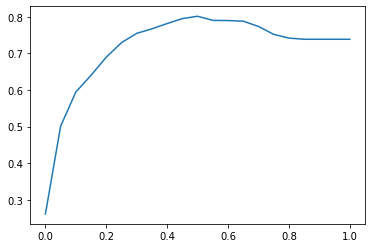

In [21]:
thresholds = np.linspace(0, 1, 21)
accuracies = []
for t in thresholds:
    acc = accuracy_score(y_val, y_pred >= t)
    accuracies.append(acc)
    
plt.plot(thresholds, accuracies)

In [22]:
from collections import Counter

Counter(y_pred >= 1.0)

Counter({False: 1860})

In [26]:
Counter(y_pred >= 0.5)

Counter({False: 1399, True: 461})

In [23]:
1 - y_val.mean()

0.7387096774193549

It becomes clear that threshold 0.5 gives the best accuracy.

In [27]:
small_subset = ['contract', 'tenure', 'totalcharges']
train_dict_small = df_train[small_subset].to_dict(orient='records')
dv_small = DictVectorizer(sparse=False)
dv_small.fit(train_dict_small)

X_small_train = dv_small.transform(train_dict_small)

model_small = LogisticRegression(solver='liblinear', random_state=1)
model_small.fit(X_small_train, y_train)

LogisticRegression(random_state=1, solver='liblinear')

In [28]:
val_dict_small = df_val[small_subset].to_dict(orient='records')
X_small_val = dv_small.transform(val_dict_small)

y_pred_small = model_small.predict_proba(X_small_val)[:, 1]

In [29]:
churn_small = (y_pred_small >= 0.5)
(churn_small == y_val).mean()

0.7672043010752688

In [30]:
accuracy_score(y_val, churn_small)

0.7672043010752688

In [31]:
size_val = len(y_val)
baseline = np.repeat(False, size_val)
baseline

array([False, False, False, ..., False, False, False])

In [32]:
accuracy_score(baseline, y_val)

0.7387096774193549

### Confusion Table

An informative to tell how frequent the model predictions are correct against actual classes.

In [33]:
actual_positive = (y_val == 1)
actual_negative = (y_val == 0)

In [34]:
t = 0.5
predict_positive = (y_pred >= 0.5)
predict_negative = (y_pred < 0.5) 

In [35]:
true_positive = (predict_positive & actual_positive).sum()
false_positive = (predict_positive & actual_negative).sum()

false_negative = (predict_negative & actual_positive).sum()
true_negative = (predict_negative & actual_negative).sum()

In [36]:
confusion_table = np.array(
    # predict neg        pos
    [[true_negative, false_positive],  # actual neg
    [false_negative, true_positive]]  # actual pos
)

confusion_table

array([[1202,  172],
       [ 197,  289]])

In [38]:
(confusion_table / confusion_table.sum()).round(3)

array([[0.646, 0.092],
       [0.106, 0.155]])

### Precision and Recall

In [39]:
precision = true_positive / (true_positive + false_positive)
recall = true_positive / (true_positive + false_negative)

precision, recall

(0.6268980477223427, 0.5946502057613169)

### ROC AUC

True positive rate (TPR) vs False positive rate (FPR)

In [44]:
scores = list()

thresholds = np.linspace(0, 1, 101)

for t in thresholds:
    actual_positive = (y_val == 1)
    actual_negative = (y_val == 0)

    predict_positive = (y_pred >= t)
    predict_negative = (y_pred < t) 
    true_positive = (predict_positive & actual_positive).sum()
    false_positive = (predict_positive & actual_negative).sum()

    false_negative = (predict_negative & actual_positive).sum()
    true_negative = (predict_negative & actual_negative).sum()
    
    scores.append((t, true_positive, false_positive, false_negative, true_negative))
    
df_scores = pd.DataFrame(scores, columns=['threshold', 'tp', 'fp', 'fn', 'tn'])

In [45]:
df_scores['tpr'] = df_scores['tp'] / (df_scores['tp'] + df_scores['fn'] )
df_scores['fpr'] = df_scores['fp'] / (df_scores['fp'] + df_scores['tn'] )
df_scores[::10]

,threshold,tp,fp,fn,tn,tpr,fpr
0,0.0,486,1374,0,0,1.000000,1.000000
10,0.1,458,726,28,648,0.942387,0.528384
20,0.2,421,512,65,862,0.866255,0.372635
30,0.3,380,350,106,1024,0.781893,0.254731
40,0.4,337,257,149,1117,0.693416,0.187045
50,0.5,289,172,197,1202,0.594650,0.125182
60,0.6,200,105,286,1269,0.411523,0.076419
70,0.7,99,34,387,1340,0.203704,0.024745
80,0.8,7,1,479,1373,0.014403,0.000728
90,0.9,0,0,486,1374,0.000000,0.000000


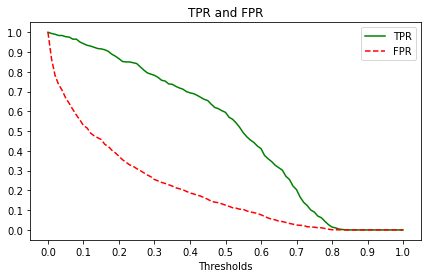

In [46]:
plt.figure(figsize=(7, 4))

plt.plot(df_scores.threshold, df_scores.tpr, color='green', linestyle='solid', label='TPR')
plt.plot(df_scores.threshold, df_scores.fpr, color='red', linestyle='dashed', label='FPR')
plt.legend()

plt.xticks(np.linspace(0, 1, 11))
plt.yticks(np.linspace(0, 1, 11))

plt.xlabel('Thresholds')
plt.title('TPR and FPR')

plt.show()

### Random Baseline

In [47]:
def tpr_fpr_dataframe(y_val, y_pred):
    """
    Generate dataframe filled with # prediction correct/incorrect 
        vs validation respecting to threshold
    """
    scores = list()

    thresholds = np.linspace(0, 1, 101)

    for t in thresholds:
        tp = ((y_pred >= t) & (y_val == 1)).sum()
        fp = ((y_pred >= t) & (y_val == 0)).sum()
        fn = ((y_pred < t) & (y_val == 1)).sum()
        tn = ((y_pred < t) & (y_val == 0)).sum()
        scores.append((t, tp, fp, fn, tn))

    df_scores = pd.DataFrame(scores, columns=['threshold', 'tp', 'fp', 'fn', 'tn'])
    df_scores['tpr'] = df_scores['tp'] / (df_scores['tp'] + df_scores['fn'] )
    df_scores['fpr'] = df_scores['fp'] / (df_scores['fp'] + df_scores['tn'] )
    
    return df_scores

In [48]:
np.random.seed(1)
y_rand = np.random.uniform(0, 1, size=len(y_val))
df_rand = tpr_fpr_dataframe(y_val, y_rand)
df_rand[::10]

,threshold,tp,fp,fn,tn,tpr,fpr
0,0.0,486,1374,0,0,1.000000,1.000000
10,0.1,440,1236,46,138,0.905350,0.899563
20,0.2,392,1101,94,273,0.806584,0.801310
30,0.3,339,972,147,402,0.697531,0.707424
40,0.4,288,849,198,525,0.592593,0.617904
50,0.5,239,723,247,651,0.491770,0.526201
60,0.6,193,579,293,795,0.397119,0.421397
70,0.7,152,422,334,952,0.312757,0.307132
80,0.8,98,302,388,1072,0.201646,0.219796
90,0.9,57,147,429,1227,0.117284,0.106987


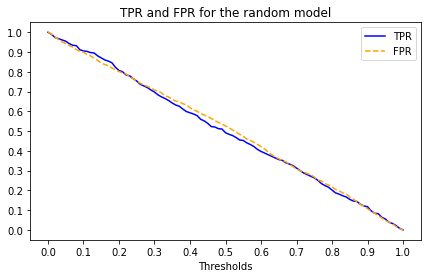

In [49]:
plt.figure(figsize=(7, 4))

plt.plot(df_rand.threshold, df_rand.tpr, color='blue', linestyle='solid', label='TPR')
plt.plot(df_rand.threshold, df_rand.fpr, color='orange', linestyle='dashed', label='FPR')
plt.legend()

plt.xticks(np.linspace(0, 1, 11))
plt.yticks(np.linspace(0, 1, 11))

plt.xlabel('Thresholds')
plt.title('TPR and FPR for the random model')

# plt.savefig('04_fpr_tpr_plot.svg')

plt.show()

### Ideal Model

In [50]:
num_neg = (y_val == 0).sum()
num_pos = (y_val == 1).sum()

num_neg, num_pos

(1374, 486)

In [51]:
y_ideal = np.repeat([0, 1], [num_neg, num_pos])
y_pred_ideal = np.linspace(0, 1, num_neg + num_pos)

df_ideal = tpr_fpr_dataframe(y_ideal, y_pred_ideal)
df_ideal[::10]

,threshold,tp,fp,fn,tn,tpr,fpr
0,0.0,486,1374,0,0,1.000000,1.000000
10,0.1,486,1188,0,186,1.000000,0.864629
20,0.2,486,1002,0,372,1.000000,0.729258
30,0.3,486,816,0,558,1.000000,0.593886
40,0.4,486,630,0,744,1.000000,0.458515
50,0.5,486,444,0,930,1.000000,0.323144
60,0.6,486,258,0,1116,1.000000,0.187773
70,0.7,486,72,0,1302,1.000000,0.052402
80,0.8,372,0,114,1374,0.765432,0.000000
90,0.9,186,0,300,1374,0.382716,0.000000


In [52]:
1 - y_val.mean()

0.7387096774193549

In [53]:
accuracy_score(y_ideal, y_pred_ideal >= 0.7387096774193549)

1.0

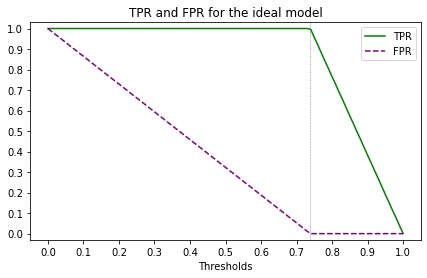

In [54]:
plt.figure(figsize=(7, 4))

plt.plot(df_ideal.threshold, df_ideal.tpr, color='green', linestyle='solid', label='TPR')
plt.plot(df_ideal.threshold, df_ideal.fpr, color='purple', linestyle='dashed', label='FPR')
plt.legend()

plt.xticks(np.linspace(0, 1, 11))
plt.yticks(np.linspace(0, 1, 11))

plt.vlines(1 - y_val.mean(), -1, 2, linewidth=0.5, linestyle='dashed', color='grey')
plt.ylim(-0.03, 1.03)

plt.xlabel('Thresholds')
plt.title('TPR and FPR for the ideal model')

# plt.savefig('04_fpr_tpr_plot.svg')

plt.show()

### Putting Everything Together



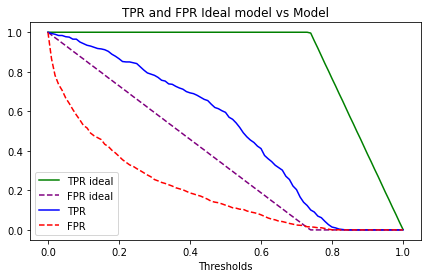

In [56]:
plt.figure(figsize=(7, 4))

plt.plot(df_ideal.threshold, df_ideal.tpr, color='green', linestyle='solid', label='TPR ideal')
plt.plot(df_ideal.threshold, df_ideal.fpr, color='purple', linestyle='dashed', label='FPR ideal')
plt.plot(df_scores.threshold, df_scores.tpr, color='blue', linestyle='solid', label='TPR')
plt.plot(df_scores.threshold, df_scores.fpr, color='red', linestyle='dashed', label='FPR')
plt.legend()

plt.xlabel('Thresholds')
plt.title('TPR and FPR Ideal model vs Model')

plt.show()

### ROC Curve

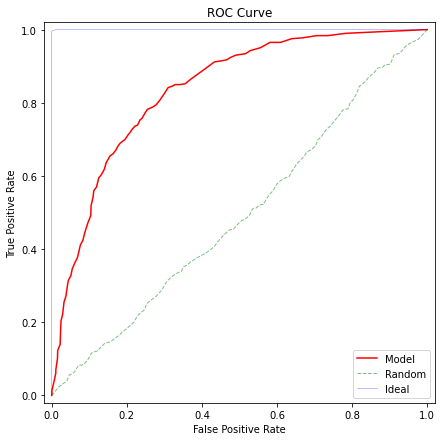

In [57]:
plt.figure(figsize=(7, 7))

plt.plot(df_scores.fpr, df_scores.tpr, color='red', linestyle='solid', label='Model')
plt.plot(df_rand.fpr, df_rand.tpr, color='green', lw = 1, 
         linestyle='dashed', alpha = 0.5, label='Random')
plt.plot(df_ideal.fpr, df_ideal.tpr, color='blue', lw = 0.5,
         linestyle='solid', alpha = 0.5, label='Ideal')
plt.legend()

plt.xlim([-0.02, 1.02])
plt.ylim([-0.02, 1.02])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')


plt.show()

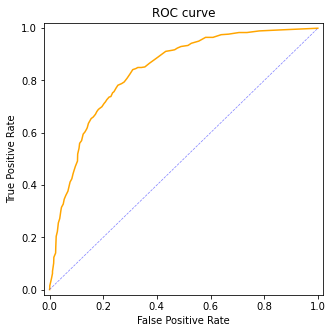

In [58]:
plt.figure(figsize=(5, 5))

plt.plot(df_scores.fpr, df_scores.tpr, color='orange')
plt.plot([0, 1], [0, 1], color='blue', lw=0.7, linestyle='dashed', alpha=0.5)

plt.xlim([-0.02, 1.02])
plt.ylim([-0.02, 1.02])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')

plt.title('ROC curve')

plt.show()

Using scikit-learn for plotting the ROC curve

In [59]:
from sklearn.metrics import roc_curve

In [60]:
fpr, tpr, thresholds = roc_curve(y_val, y_pred)

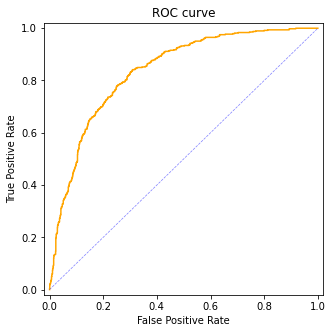

In [61]:
plt.figure(figsize=(5, 5))

## Plotting results from roc_curve calculation
plt.plot(fpr, tpr, color='orange')
plt.plot([0, 1], [0, 1], color='blue', lw=0.7, linestyle='dashed', alpha=0.5)

plt.xlim([-0.02, 1.02])
plt.ylim([-0.02, 1.02])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')

plt.title('ROC curve')

plt.show()

### AUC: Area under the ROC curve

In [62]:
from sklearn.metrics import auc

In [63]:
df_scores_small = tpr_fpr_dataframe(y_val, y_pred_small)
auc(df_scores_small.fpr, df_scores_small.tpr)

0.8108718050089552

In [64]:
auc(df_scores.fpr, df_scores.tpr)

0.8359001084215382

In [65]:
auc(df_ideal.fpr, df_ideal.tpr)

0.9999760394390833

Comparing multiple models with ROC curves

In [66]:
fpr_large, tpr_large, _ = roc_curve(y_val, y_pred)
auc(fpr_large, tpr_large)

0.8363396349608545

In [67]:
fpr_small, tpr_small, _ = roc_curve(y_val, y_pred_small)
auc(fpr_small, tpr_small)

0.8117942866042492

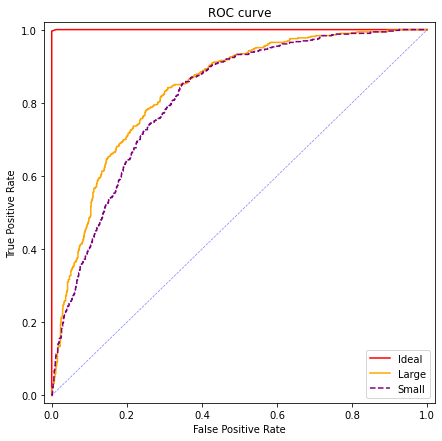

In [68]:
plt.figure(figsize=(7, 7))

plt.plot(df_ideal.fpr, df_ideal.tpr, color='red', linestyle='solid', label="Ideal")
plt.plot(fpr_large, tpr_large, color='orange', linestyle='solid', label="Large")
plt.plot(fpr_small, tpr_small, color='purple', linestyle='dashed', label="Small")
plt.plot([0, 1], [0, 1], color='blue', lw=0.7, linestyle='dashed', alpha=0.5)

plt.xlim([-0.02, 1.02])
plt.ylim([-0.02, 1.02])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')

plt.title('ROC curve')
plt.legend(loc='lower right')

plt.show()

Score on ROC AUC

In [69]:
from sklearn.metrics import roc_auc_score

roc_auc_score(y_val, y_pred)

0.8363396349608545

In [70]:
roc_auc_score(y_val, y_pred_small)

0.8117942866042492

Interpretation of AUC: the probability that a randomly chosen positive example ranks higher than a randomly chosen negative example

In [71]:
neg = y_pred[y_val == 0]
pos = y_pred[y_val == 1]

In [72]:
np.random.seed(1)
neg_choice = np.random.randint(low=0, high=len(neg), size=10000)
pos_choice = np.random.randint(low=0, high=len(pos), size=10000)
(pos[pos_choice] > neg[neg_choice]).mean()

0.8356

In [74]:
import random

n = 10000
success = 0 

for i in range(n):
    pos_ind = random.randint(0, len(pos) - 1)
    neg_ind = random.randint(0, len(neg) - 1)

    if pos[pos_ind] > neg[neg_ind]:
        success = success + 1

success / n

0.8369

### K-fold cross validation

In [65]:
def train(df, y):
    cat = df[categorical + numerical].to_dict(orient='records')
    
    dv = DictVectorizer(sparse=False)
    dv.fit(cat)

    X = dv.transform(cat)

    model = LogisticRegression(solver='liblinear')
    model.fit(X, y)

    return dv, model


def predict(df, dv, model):
    cat = df[categorical + numerical].to_dict(orient='records')
    
    X = dv.transform(cat)

    y_pred = model.predict_proba(X)[:, 1]

    return y_pred

In [61]:
from sklearn.model_selection import KFold

In [62]:
kfold = KFold(n_splits=10, shuffle=True, random_state=1)

In [66]:
aucs = []

for train_idx, val_idx in kfold.split(df_train_full):
    df_train = df_train_full.iloc[train_idx]
    y_train = df_train.churn.values

    df_val = df_train_full.iloc[val_idx]
    y_val = df_val.churn.values

    dv, model = train(df_train, y_train)
    y_pred = predict(df_val, dv, model)

    rocauc = roc_auc_score(y_val, y_pred)
    aucs.append(rocauc)

In [67]:
np.array(aucs).round(3)

array([0.849, 0.841, 0.859, 0.833, 0.824, 0.841, 0.844, 0.824, 0.845,
       0.861])

In [68]:
print('auc = %0.3f ± %0.3f' % (np.mean(aucs), np.std(aucs)))

auc = 0.842 ± 0.012


Tuning the parameter `C`

In [69]:
def train(df, y, C=1.0):
    cat = df[categorical + numerical].to_dict(orient='records')
    
    dv = DictVectorizer(sparse=False)
    dv.fit(cat)

    X = dv.transform(cat)

    model = LogisticRegression(solver='liblinear', C=C)
    model.fit(X, y)

    return dv, model

In [70]:
nfolds = 5
kfold = KFold(n_splits=nfolds, shuffle=True, random_state=1)

for C in [0.001, 0.01, 0.1, 0.5, 1, 10]:
    aucs = []

    for train_idx, val_idx in kfold.split(df_train_full):
        df_train = df_train_full.iloc[train_idx]
        df_val = df_train_full.iloc[val_idx]

        y_train = df_train.churn.values
        y_val = df_val.churn.values

        dv, model = train(df_train, y_train, C=C)
        y_pred = predict(df_val, dv, model)
        
        auc = roc_auc_score(y_val, y_pred)
        aucs.append(auc)

    print('C=%s, auc = %0.3f ± %0.3f' % (C, np.mean(aucs), np.std(aucs)))

C=0.001, auc = 0.825 ± 0.013
C=0.01, auc = 0.839 ± 0.009
C=0.1, auc = 0.841 ± 0.007
C=0.5, auc = 0.841 ± 0.007
C=1, auc = 0.841 ± 0.007
C=10, auc = 0.841 ± 0.007


### Full Retrain

In [71]:
y_train = df_train_full.churn.values
y_test = df_test.churn.values

dv, model = train(df_train_full, y_train, C=0.5)
y_pred = predict(df_test, dv, model)

auc = roc_auc_score(y_test, y_pred)
print('auc = %.3f' % auc)

auc = 0.858
